In [1]:
%pylab inline
import scanpy as sc
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def postprocess(adata,view=True):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    print('after select HVG',adata.shape)
    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    if view:
        sc.tl.tsne(adata)
        sc.tl.umap(adata)
    return adata

In [3]:
def cluster_k_leiden(embadata,n_cluster):
    max_steps=120
    this_step = 0
    this_min = 0
    this_max = 2
    print('reference cluster number',n_cluster)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.leiden(embadata,resolution=this_resolution,random_state=42)
        this_clusters = embadata.obs['leiden'].nunique()
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:break
        this_step+=1
    if this_step==max_steps:
        print('Cannot find the number of clusters')
        print('Use resolution',this_resolution)
    else:
        print('use resolution',this_resolution)
     # leiden
    sc.tl.leiden(embadata,resolution=this_resolution,random_state=42,key_added=f'cluster_{n_cluster}')

In [9]:
refdf = pd.read_csv('./data/baron_human_ref_19264_fromsaver.csv',index_col=0)
refAdata = sc.AnnData(refdf)
refAdata = postprocess(refAdata,True)

/tmp/ipykernel_23453/3373997899.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  refAdata = sc.AnnData(refdf)


after select HVG (1076, 432)


/opt/conda/envs/scvi/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/envs/scvi/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [10]:
sc.tl.leiden(refAdata,resolution=0.6)

In [11]:
numcls = refAdata.obs.leiden.unique().shape[0]
numcls

7

In [12]:
numcls=7
imputeemb = np.load(f'./data/Baron_noresolution.npy')
imputeAdata = sc.AnnData(pd.DataFrame(imputeemb,index=refdf.index))
sc.pp.scale(imputeAdata)
sc.tl.pca(imputeAdata)
sc.pp.neighbors(imputeAdata)
sc.tl.umap(imputeAdata)

cluster_k_leiden(imputeAdata,numcls)
imputeAdata.obs['refleiden']=refAdata.obs['leiden']

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


reference cluster number 7
use resolution 0.625


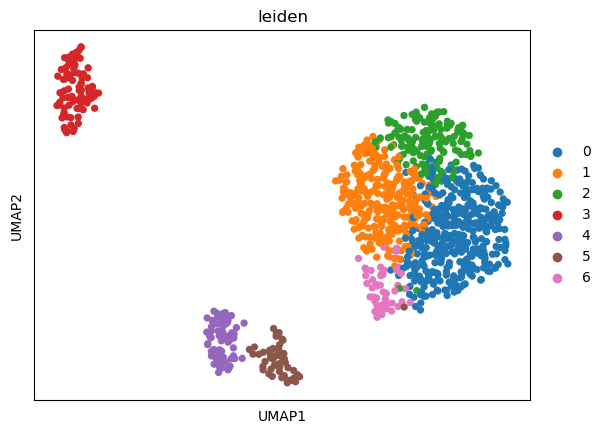

In [13]:
sc.pl.umap(imputeAdata,color='leiden')

In [14]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score,calinski_harabasz_score,silhouette_score

In [15]:
normalized_mutual_info_score(imputeAdata.obs[f'refleiden'], imputeAdata.obs[f'cluster_{numcls}'])

0.5618125668333621

In [16]:
adjusted_rand_score(imputeAdata.obs[f'refleiden'], imputeAdata.obs[f'cluster_{numcls}'])

0.37158413835707405

In [17]:
silhouette_score(refAdata.obsm[f'X_pca'],imputeAdata.obs[f'cluster_{numcls}'])

0.06631905

### Zheng

In [4]:
label = np.load('./data/zheng68k_label.npy',allow_pickle=True)

In [6]:
imputeemb = np.load('./data/zheng68k_nores_nores_singlecell_cell_embedding_f1_resolution.npy')

numcls = np.unique(label).shape[0]

imputeAdata = sc.AnnData(pd.DataFrame(imputeemb))
sc.pp.scale(imputeAdata)
sc.tl.pca(imputeAdata)
sc.pp.neighbors(imputeAdata)
sc.tl.umap(imputeAdata)
imputeAdata.obs['label']=label.tolist()

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [21]:
silhouette_score(imputeAdata.obsm['X_pca'],label)

0.11451183

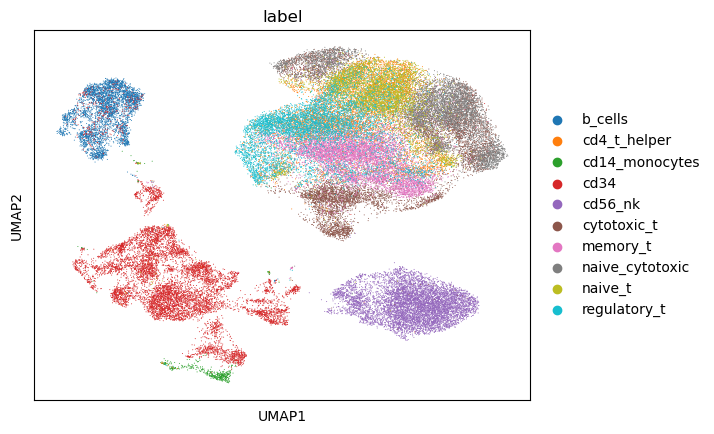

In [8]:
sc.pl.umap(imputeAdata,color='label')